# Settings

In [3]:
%conda activate DiffuserCam
%pip install numpy matplotlib torch torchvision scipy Pillow imageio


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 11.8 MB/s eta 0:00:00
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:0000:0100:01
  Using cached Jinja2-3.1.2-py3-none-any.whl (13

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import imageio
import scipy.io
from PIL import Image, ImageOps
from torch.utils.data import random_split


ModuleNotFoundError: No module named 'numpy'

In [ ]:
from functools import partial
import pickle
import numpy as np
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torchmetrics import TotalVariation
import matplotlib.pyplot as plt
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import imageio
import scipy.io
from PIL import Image, ImageOps

# Pytorch
dtype = torch.float32
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
torch.backends.cudnn.benchmark=True; torch.backends.cudnn.deterministic=False

In [ ]:

def exportGIF(im, file):
  # "ReLU"
  rec = torch.maximum(im, torch.zeros(im.shape).to(device=device)).detach().cpu()
  # Normalize to [0,255] for imagio
  rec /= np.max(rec.numpy(), axis=(1,2))[..., None, None]
  rec *= 255
  imageio.mimsave(f"drive/MyDrive/DiffuserCam/Images/reconstructions/3D/3D{file}.gif", rec, loop=100)

In [ ]:
# constants
M, N, Z = 270, 320, 44
psf_bias = 102
image_bias = 100

data_dir="drive/MyDrive/DiffuserCam"

# Load Data

In [ ]:
def load_data(data_dir="drive/MyDrive/DiffuserCam"):
  # ground
  ground_mat_file_name = f"{data_dir}/Images/ground/xhat.mat"
  ground_var_name = "xhat"

  # psf
  impulse_mat_file_name = f"{data_dir}/Images/psf/example_psfs.mat"
  impulse_var_name = "psf"

  # raw
  image_file = f"{data_dir}/Images/raw/example_raw.png"
  color_to_process = "mono"

  # padding (2M, 2N)
  padding = (N // 2, N // 2, M // 2, M // 2)

  # Ground Truth
  pre_ground = np.array(scipy.io.loadmat(ground_mat_file_name)[ground_var_name])
  ground = np.empty((M*2, N*2, 0))
  for i in range(Z):
    img = Image.fromarray(pre_ground[:,:,i])
    ground = np.append(ground, np.atleast_3d(img), axis=2)
  ground = transforms.ToTensor()(ground).to(device=device, dtype=dtype)

  # PSF
  pre_psf = transforms.ToTensor()(np.array(scipy.io.loadmat(impulse_mat_file_name)[impulse_var_name])).to(device=device, dtype=dtype)
  psf = torch.zeros((Z, M*2, N*2)).to(device=device, dtype=dtype)
  for i in range(len(psf)):
    psf[i] = F.pad(pre_psf[i], padding, "constant")
  psf -= psf_bias
  psf = torch.maximum(psf, torch.zeros(psf.shape).to(device=device, dtype=dtype))

  # RAW = b
  raw = transforms.ToTensor()(Image.open(image_file)).to(device=device, dtype=dtype)
  raw -= image_bias
  raw /= torch.max(raw)
  raw = torch.maximum(raw, torch.zeros(raw.shape).to(device=device, dtype=dtype))

  return ground, psf, raw

ground, psf, raw = load_data(data_dir)

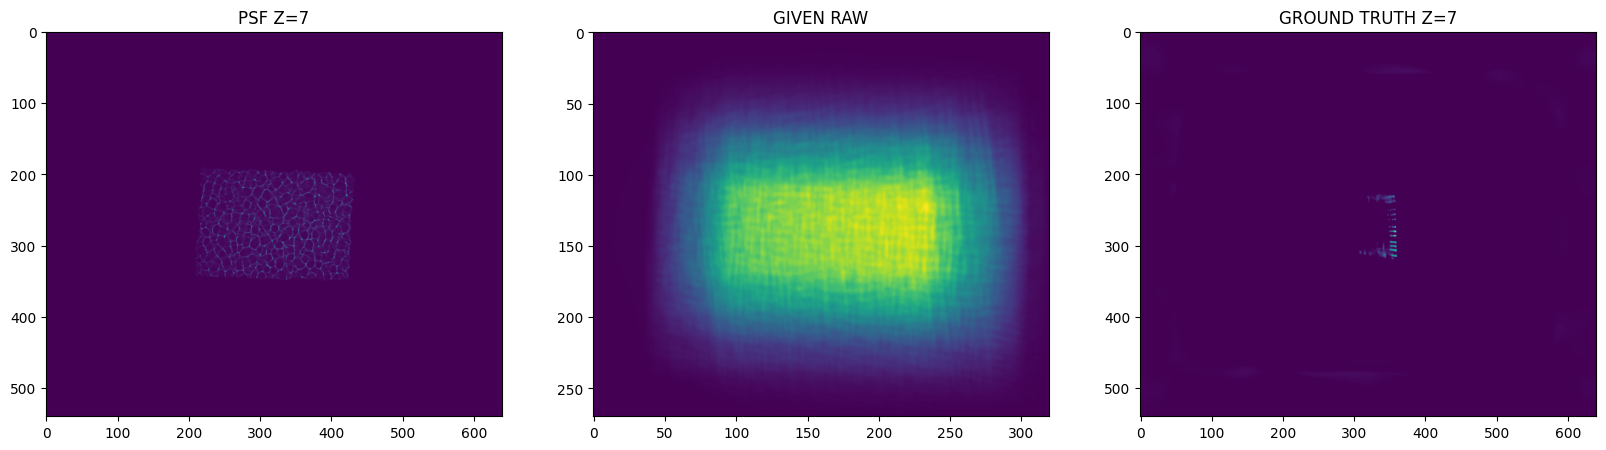

In [ ]:
 # Display
fig, ax = plt.subplots(1,3,figsize=(20,10))

# Plot psf and data
ax[0].imshow(psf[7].cpu())
ax[0].title.set_text("PSF Z=7")
ax[1].imshow(raw.cpu().squeeze())
ax[1].title.set_text("GIVEN RAW")
ax[2].imshow(ground[7].cpu())
ax[2].title.set_text("GROUND TRUTH Z=7")

# Rotate Data 3D

In [ ]:
def rotate2D(im, theta):
  # Create Rotation Matrix
  R = torch.tensor([[np.cos(theta), -np.sin(theta), 0],
                    [np.sin(theta), np.cos(theta), 0]]).to(device=device,dtype=dtype)
  R = R.unsqueeze(0)

  # Rotate
  im = im[..., None].permute(0, -1, 1, 2).to(device=device, dtype=dtype)
  grid = F.affine_grid(R, im.size(), align_corners=False)
  im = F.grid_sample(im, grid, align_corners=False, mode='bilinear', padding_mode='zeros')

  return im

def rotate3D(im, u, theta):
  # Create Rotation Matrix
  u_x, u_y, u_z = u # Rotate on z-axis by 180 degrees
  R = torch.tensor([[np.cos(theta)+u_x**2*(1-np.cos(theta)), u_x*u_y*(1-np.cos(theta))-u_z*np.sin(theta), u_x*u_z*(1-np.cos(theta))+u_y*np.sin(theta)],
                    [u_y*u_x*(1-np.cos(theta))+u_z*np.sin(theta), np.cos(theta)+u_y**2*(1-np.cos(theta)), u_y*u_z*(1-np.cos(theta))-u_x*np.sin(theta)],
                    [u_z*u_x*(1-np.cos(theta))-u_y*np.sin(theta), u_z*u_y*(1-np.cos(theta))+u_x*np.sin(theta), np.cos(theta)+u_z**2*(1-np.cos(theta))]]).to(device=device, dtype=dtype)
  R = torch.concatenate((R, torch.tensor([[0], [0], [0]]).to(device=device, dtype=dtype)), axis=1)
  R = R.unsqueeze(0)

  # Rotate
  im = im[None, ..., None].permute(0, -1, 1, 2, 3).to(device=device, dtype=dtype)
  grid = F.affine_grid(R, im.size(), align_corners=False)
  im = F.grid_sample(im, grid, align_corners=False, mode='bilinear', padding_mode='zeros')

  return im.squeeze()

u = torch.tensor([0, 0, 1]).to(device=device, dtype=dtype)
r_psf = rotate3D(psf, u, np.pi)
r_ground = rotate3D(ground, u, np.pi)
r_raw = rotate2D(raw, np.pi)

In [ ]:
def rotate3D(grid, im, u, theta):
  # Create Rotation Matrix
  u_x, u_y, u_z = u # Rotate on z-axis by 180 degrees
  R = torch.tensor([[np.cos(theta)+u_x**2*(1-np.cos(theta)), u_x*u_y*(1-np.cos(theta))-u_z*np.sin(theta), u_x*u_z*(1-np.cos(theta))+u_y*np.sin(theta)],
                    [u_y*u_x*(1-np.cos(theta))+u_z*np.sin(theta), np.cos(theta)+u_y**2*(1-np.cos(theta)), u_y*u_z*(1-np.cos(theta))-u_x*np.sin(theta)],
                    [u_z*u_x*(1-np.cos(theta))-u_y*np.sin(theta), u_z*u_y*(1-np.cos(theta))+u_x*np.sin(theta), np.cos(theta)+u_z**2*(1-np.cos(theta))]]).to(device=device, dtype=dtype)
  #R = torch.concatenate((R, torch.tensor([[0], [0], [0]]).to(device=device, dtype=dtype)), axis=1)

  # Rotate
  z, y, x = grid
  X, Y, Z = np.meshgrid(x, y, z)
  X, Y, Z = X * 3, Y * 2, Z * 5

  coords = torch.tensor(np.stack((X.ravel(), Y.ravel(), Z.ravel()), axis=-1)).to(device=device, dtype=dtype)
  rot_coords = (coords @ R).to(dtype=int)

  I, J, K = rot_coords[:,0], rot_coords[:,1], rot_coords[:,2]
  I -= I.min()
  J -= J.min()
  K -= K.min()

  rotated_im = torch.zeros(I.max()+1, J.max()+1, K.max()+1)
  print(K.)
  rotated_im[K, J, I] = im[Z.astype(int), Y.astype(int), X.astype(int)]

  return rotated_im

dx, dy, dz = 1/3, 1/2, 1/5
grid = [np.arange(0, ground.shape[0]) * dz, np.arange(0, ground.shape[1]) * dy, np.arange(0, ground.shape[2]) * dx]
rotate3D(grid, ground, torch.tensor([1, 0, 0]), np.pi)

SyntaxError: ignored

In [ ]:
exportGIF()

In [ ]:
exportGIF(r_psf, "rotated_psf")
exportGIF(r_ground, "rotated_ground")

In [ ]:
fig, axs = plt.subplots(2)
axs[0].imshow(r_ground[5].cpu())
axs[1].imshow(ground[5].cpu())

# Forward

In [ ]:
# FFT Algorithms
def conv2d(x, psf):
  #x, psf = x.squeeze(), psf.squeeze()

  x_f = torch.fft.fft2(x)
  psf_f = torch.fft.fft2(psf)
  conv = torch.fft.ifft2(x_f * psf_f)
  conv = torch.fft.ifftshift(conv).real
  return conv

In [ ]:
# Forward Model
def fft_forward(x, psf):
  forward = torch.zeros(1, M*2, N*2).to(device=device, dtype=dtype)
  for i in range(Z):
    forward += conv2d(x[i], psf[i])
  return forward

# Test Forward
ground_raw = fft_forward(r_ground, r_psf)
ground_raw /= torch.max(ground_raw)

# Display
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(ground_raw.cpu().squeeze())
ax[0].title.set_text("Forward Raw Processed On Ground")
ax[1].imshow(r_raw.cpu().squeeze())
ax[1].title.set_text("Given Raw")

# Model

In [ ]:
class Convolution_FFT(nn.Module):
  def __init__(self, image_height, image_width, depth, noise, u, theta):
    super().__init__()

    # Flatten Image Size
    self.image_width = image_width
    self.image_height = image_height
    self.depth = depth
    self.weight = nn.Parameter(noise * torch.rand(depth, image_height, image_width).to(device=device, dtype=dtype))
    self.u = u
    self.theta = theta

  def forward(self, input):
    forward = torch.zeros(1, self.image_height, self.image_width).to(device=device, dtype=dtype)
    rotated_weights = rotate3D(self.weight, self.u, self.theta)
    for i in range(self.depth):
      forward += conv2d(rotated_weights[i], input[i])
    return forward[:, self.image_height//4:~self.image_height//4+1, self.image_width//4:~self.image_width//4+1]

# Training with Tuning

In [ ]:
def train(config, checkpoint_dir=None, data_dir=None, epochs=5000):
  model = Convolution_FFT(config["M"], config["N"], config["Z"], config["noise"])
  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
      model = nn.DataParallel(model)
  model = model.to(device=device)

  mse_fn = nn.MSELoss().to(device=device)
  tv_fn = TotalVariation().to(device=device)
  def criterion(forward):
    l1_regularization = config["l1"] * torch.norm(model.weight, 1)
    tv_regularization = config["tv"] * tv_fn(model.weight.unsqueeze(0))
    mse_loss = mse_fn(forward, raw)
    return mse_loss + l1_regularization + tv_regularization
  optimizer = optim.Adam(model.parameters(), lr=config["lr"])

  # if checkpoint_dir:
  #     model_state, optimizer_state = torch.load(
  #         os.path.join(checkpoint_dir, "checkpoint"),
  #         map_location=torch.device('cpu')
  #     )
  #     model.load_state_dict(model_state)
  #     optimizer.load_state_dict(optimizer_state)

  running_loss = np.array([])
  for epoch in range(epochs):
    # model.train()
    optimizer.zero_grad()

    forward = model(psf)
    loss = criterion(forward)
    loss.backward()
    optimizer.step()

    model.weight.data = torch.maximum(model.weight, torch.zeros(model.weight.shape).to(device=device, dtype=dtype))

    # Log Statistics
    log_loss = np.log(loss.item())
    running_loss = np.append(running_loss, log_loss)

    # Print Statistics
    if epoch % 10 == 0:
      plt.plot(np.arange(0, len(running_loss)), running_loss)
      plt.show()
      plt.close()
      print('Epoch %d, loss = %.16f' % (epoch, log_loss))

    # Tuning
    # with tune.checkpoint_dir(epoch) as checkpoint_dir:
    #   path = os.path.join(checkpoint_dir, "checkpoint")
    #   torch.save((model.state_dict(), optimizer.state_dict()), path)

    tune.report(loss=log_loss)

In [ ]:
# Settings
max_num_epochs = 1000
config = {
    "l1": tune.loguniform(1e-11, 1e-8),
    "tv": tune.loguniform(1e-11, 1e-8),
    "noise": tune.loguniform(1e-11, 1e-8),
    "lr": tune.loguniform(1e-11, 1e-8),
    "N": 640,
    "M": 540,
    "Z": 44
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2
)
reporter = CLIReporter(
    metric_columns=["loss", "training_iteration"]
)
result = tune.run(
    partial(train, data_dir=data_dir),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=5,
    scheduler=scheduler,
    progress_reporter=reporter
)

2023-10-03 17:07:03,560	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-03 17:07:06,455	INFO tune.py:228 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-10-03 17:07:06,459	INFO tune.py:654 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


DeprecationWarning: ignored

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))

# Training No Tuning

In [ ]:
def model_train(config, model=None, epochs=200):
  if not model:
    model = Convolution_FFT(config["M"], config["N"], config["Z"], config["noise"], config["u"], config["theta"])
    model = model.to(device=device)

  mse_fn = nn.MSELoss().to(device=device)
  tv_fn = TotalVariation().to(device=device)
  def criterion(forward):
    l1_regularization = config["l1"] * torch.norm(model.weight, 1)
    tv_regularization = config["tv"] * tv_fn(model.weight.unsqueeze(0))
    mse_loss = mse_fn(forward, raw)
    return mse_loss + l1_regularization + tv_regularization
  optimizer = optim.Adam(model.parameters(), lr=config["lr"])

  running_loss = np.array([])
  for epoch in range(epochs):
    # model.train()
    optimizer.zero_grad()

    forward = model(psf)
    loss = criterion(forward)
    loss.backward()
    optimizer.step()

    model.weight.data = torch.maximum(model.weight, torch.zeros(model.weight.shape).to(device=device, dtype=dtype))

    # Log Statistics
    log_loss = np.log(loss.item())
    running_loss = np.append(running_loss, log_loss)

    # Print Statistics
    if epoch % 10 == 0:
      plt.plot(np.arange(0, len(running_loss)), running_loss)
      plt.show()
      plt.close()
      print('Epoch %d, loss = %.16f' % (epoch, log_loss))

  return model

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `TotalVariation` from `torchmetrics` was deprecated and will be removed in 2.0. Import `TotalVariation` from `torchmetrics.image` instead.
  _future_warning(


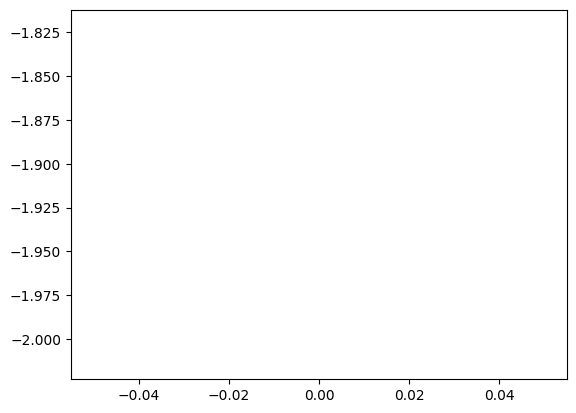

Epoch 0, loss = -1.9175006104591972


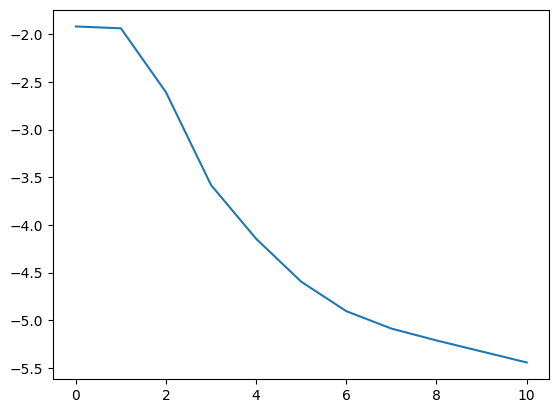

Epoch 10, loss = -5.4436202888136904


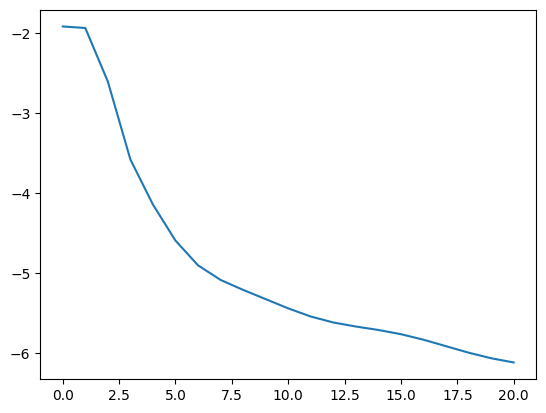

Epoch 20, loss = -6.1202397440399645


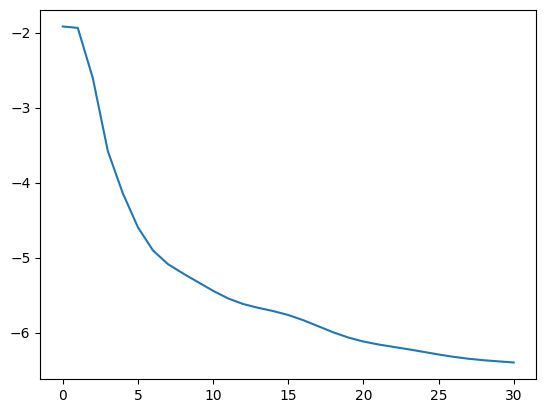

Epoch 30, loss = -6.3998210233775774


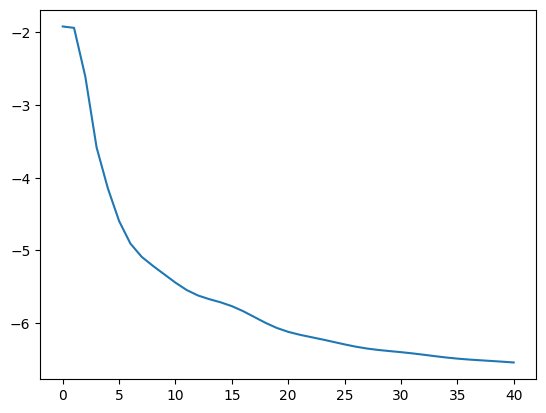

Epoch 40, loss = -6.5418185136591802


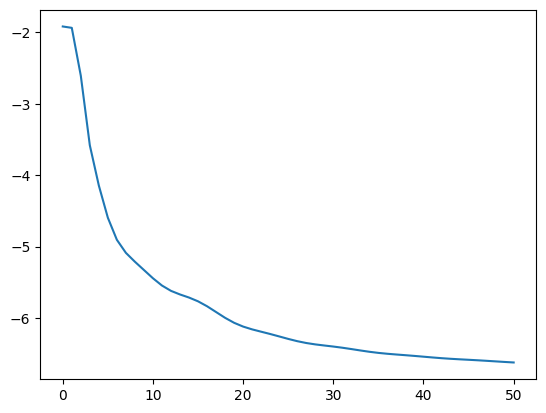

Epoch 50, loss = -6.6228974501474411


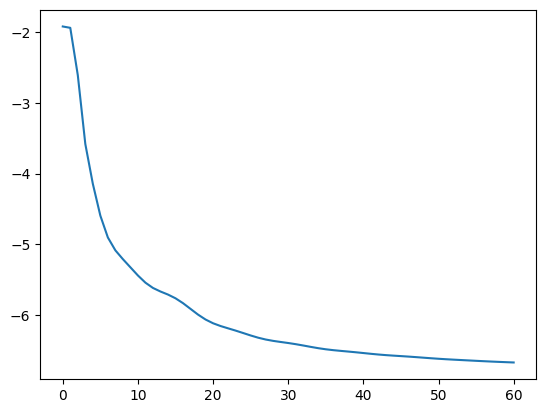

Epoch 60, loss = -6.6754356552635485


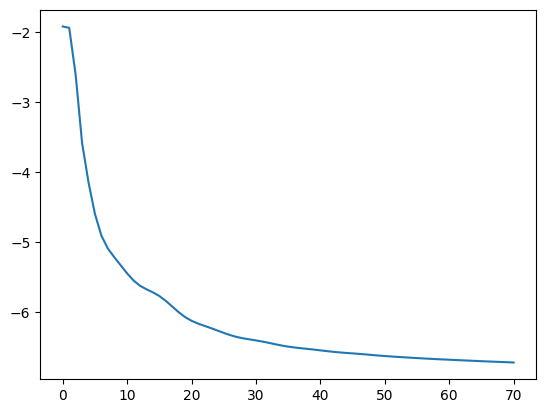

Epoch 70, loss = -6.7148022983865507


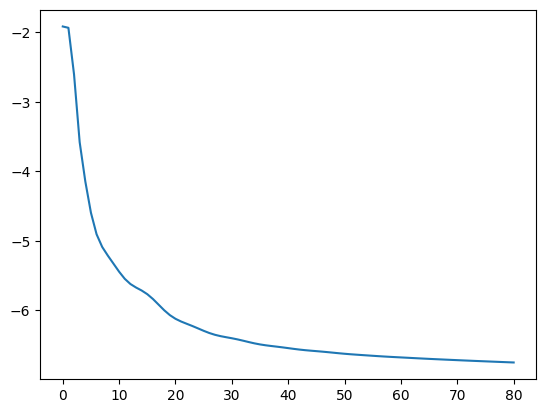

Epoch 80, loss = -6.7481282138436525


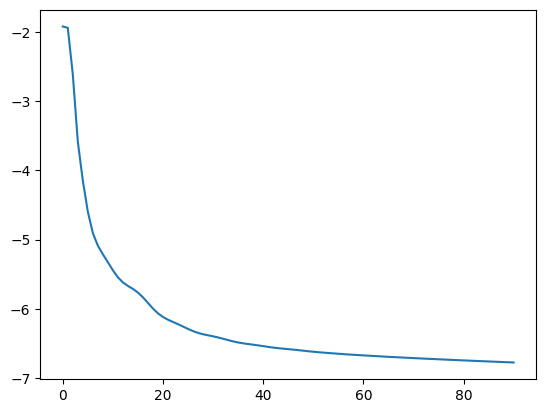

Epoch 90, loss = -6.7781926187803769


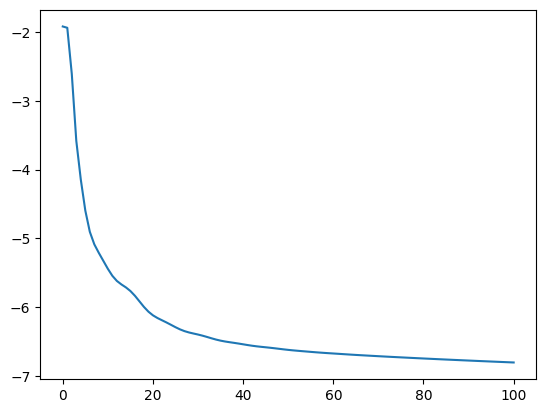

Epoch 100, loss = -6.8062338861551748


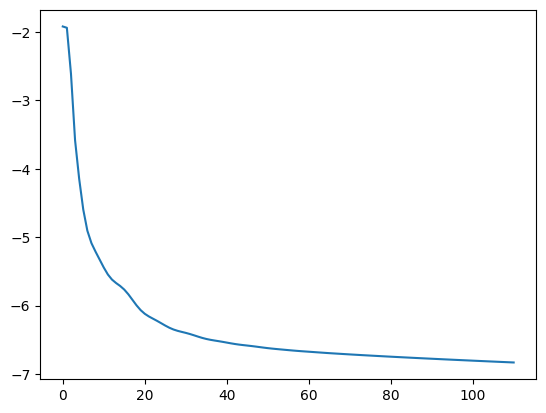

Epoch 110, loss = -6.8328748842889722


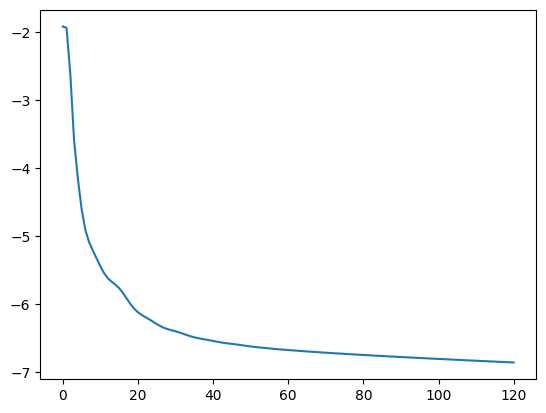

Epoch 120, loss = -6.8584449647178749


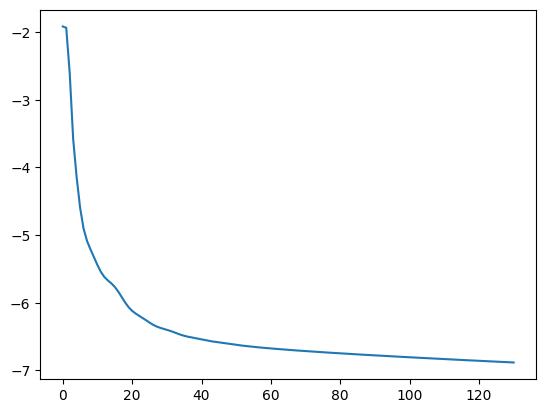

Epoch 130, loss = -6.8830343814802974


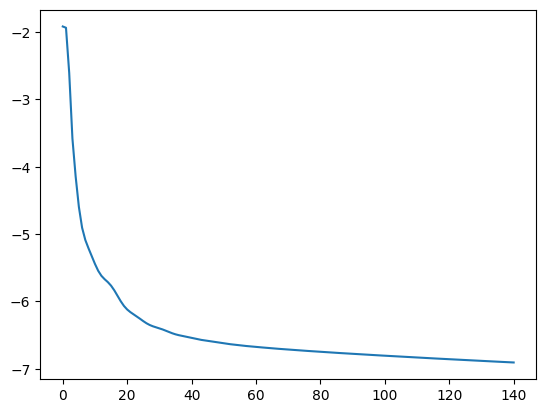

Epoch 140, loss = -6.9067365344385738


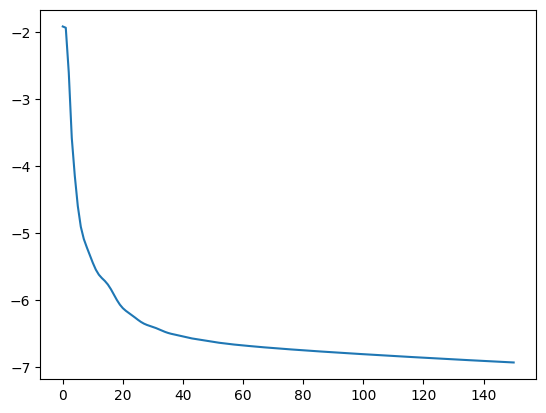

Epoch 150, loss = -6.9297060876796683


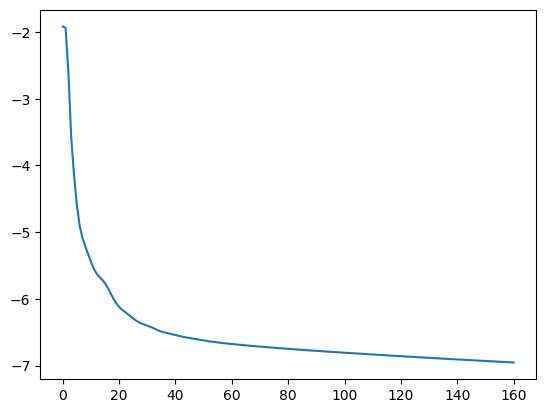

Epoch 160, loss = -6.9520539064040889


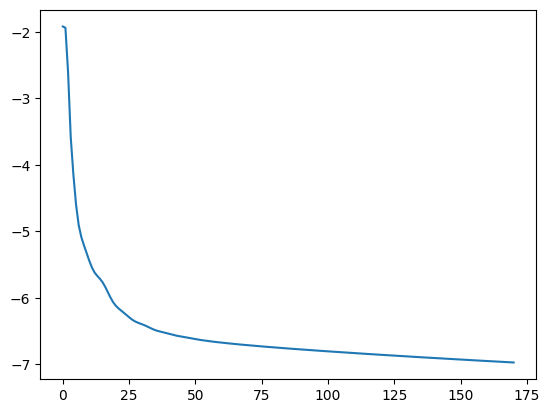

Epoch 170, loss = -6.9737353687025712


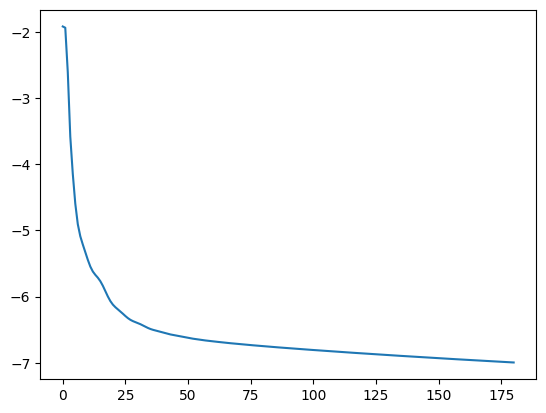

Epoch 180, loss = -6.9946753747778914


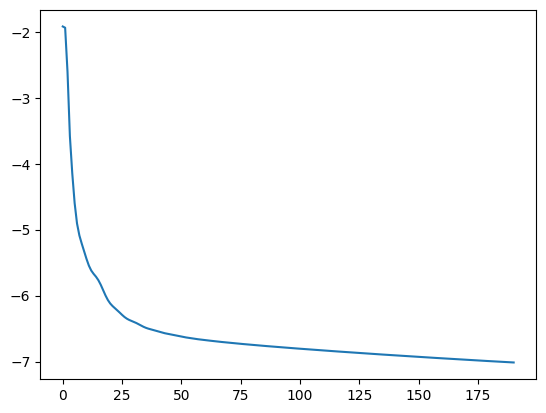

Epoch 190, loss = -7.0148027337341947


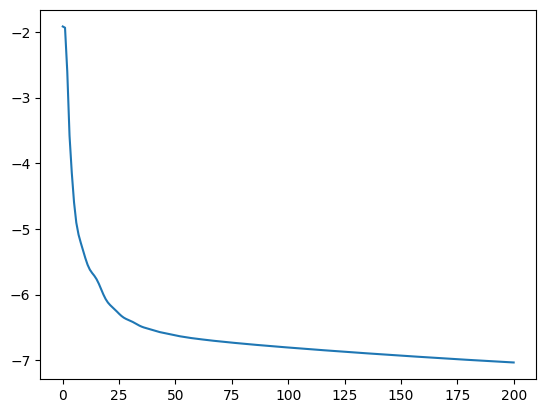

Epoch 200, loss = -7.0340658203813611


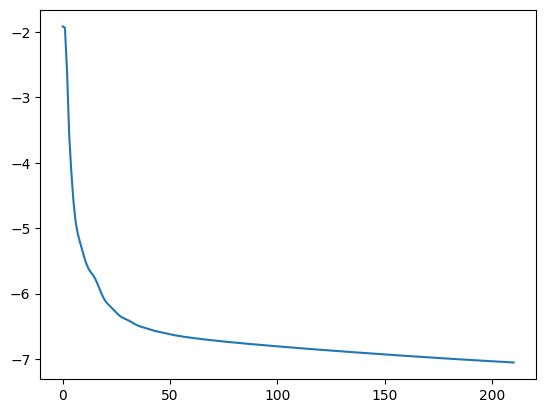

Epoch 210, loss = -7.0524908518580043


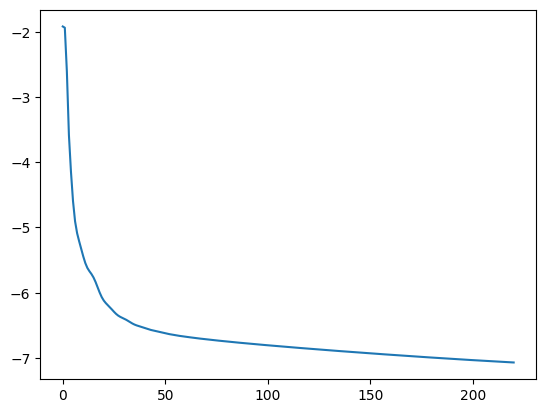

Epoch 220, loss = -7.0700687090558896


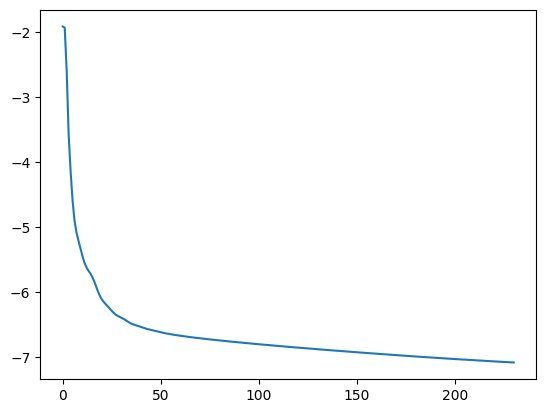

Epoch 230, loss = -7.0867721248780979


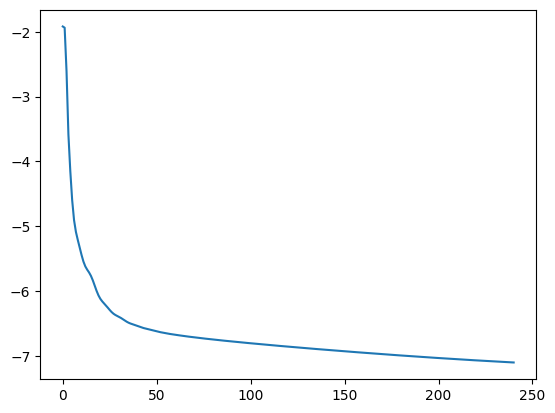

Epoch 240, loss = -7.1026499368842284


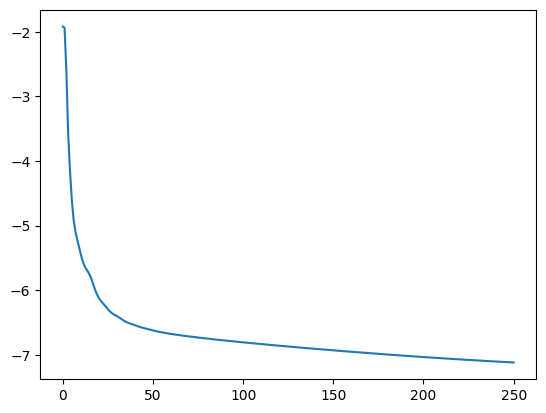

Epoch 250, loss = -7.1177471148753986


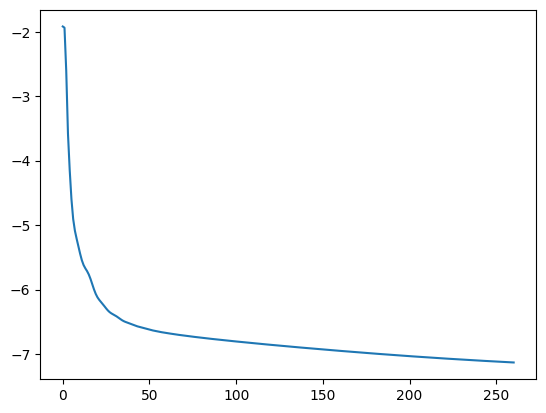

Epoch 260, loss = -7.1321178117979729


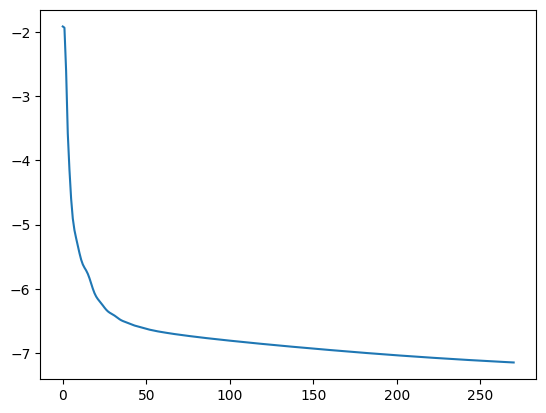

Epoch 270, loss = -7.1458080912396618


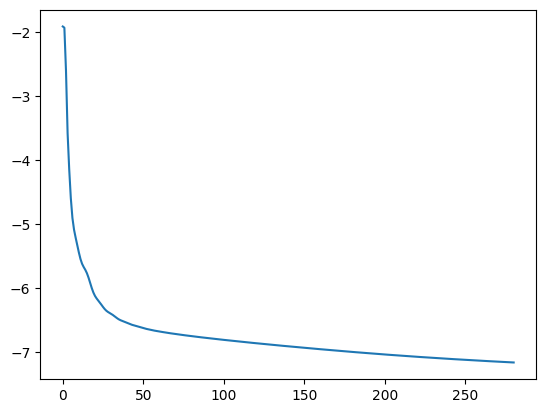

Epoch 280, loss = -7.1588581222499998


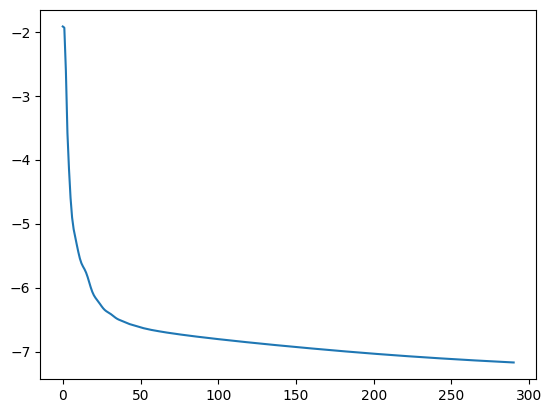

Epoch 290, loss = -7.1713148582682020


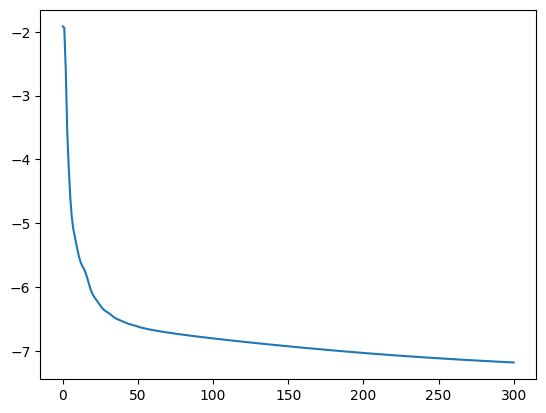

Epoch 300, loss = -7.1832101723585762


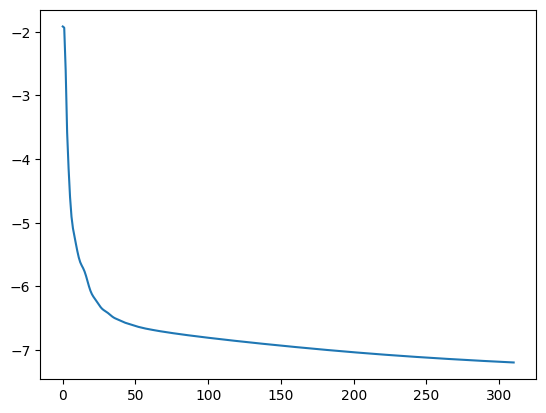

Epoch 310, loss = -7.1945691062542734


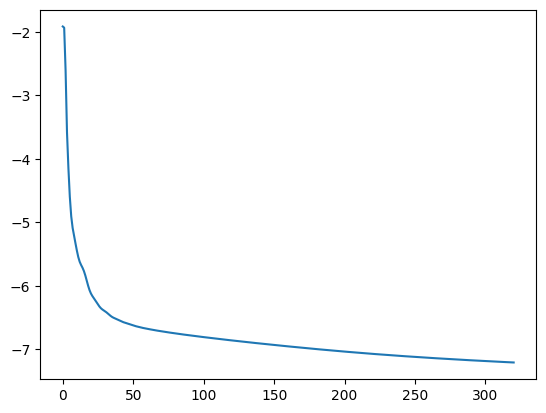

Epoch 320, loss = -7.2054121863051268


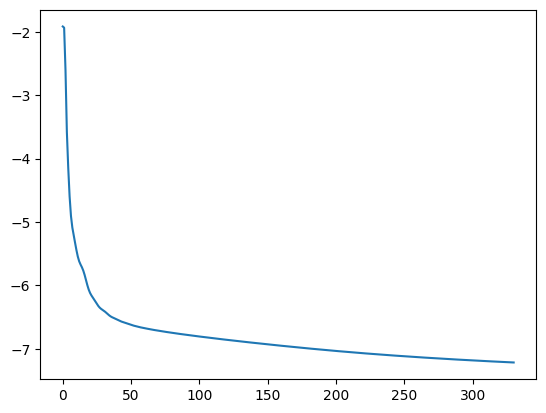

Epoch 330, loss = -7.2157586074803843


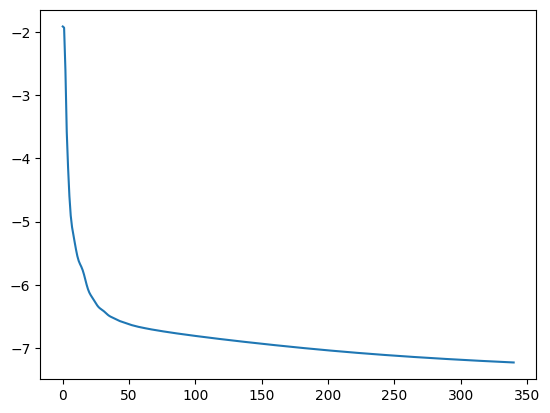

Epoch 340, loss = -7.2256395846225194


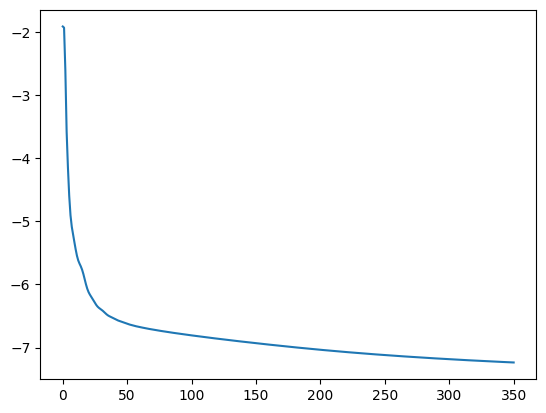

Epoch 350, loss = -7.2350793818370027


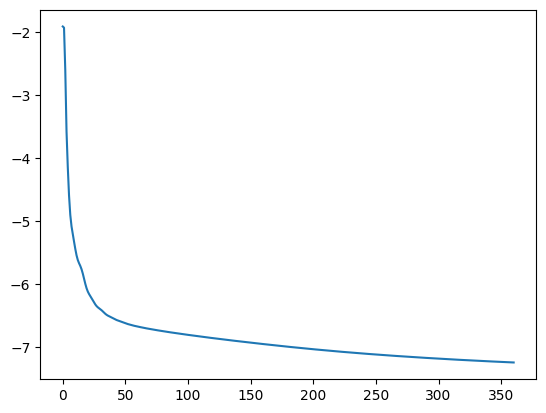

Epoch 360, loss = -7.2441149124711952


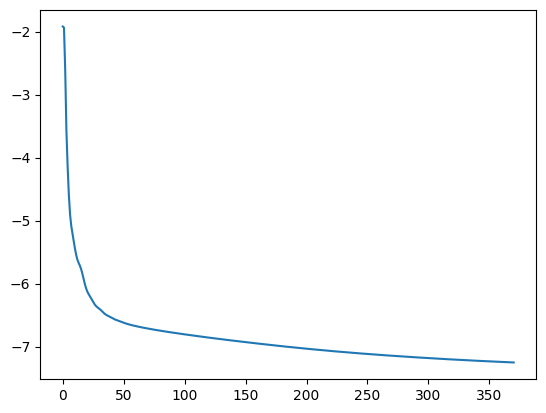

Epoch 370, loss = -7.2527566783286321


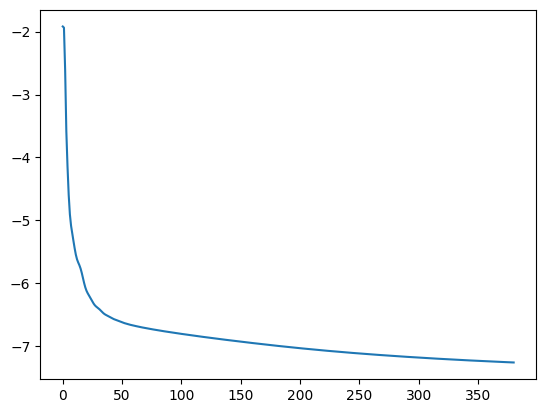

Epoch 380, loss = -7.2610377730499991


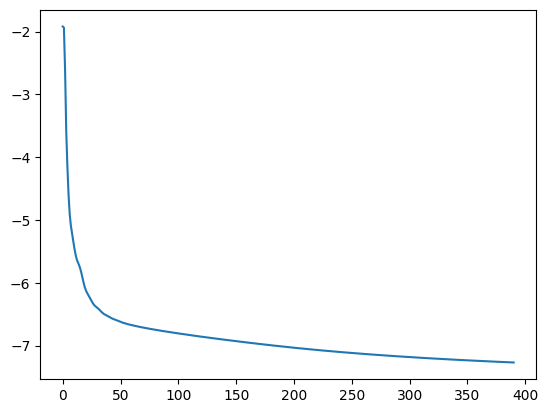

Epoch 390, loss = -7.2689746963960546


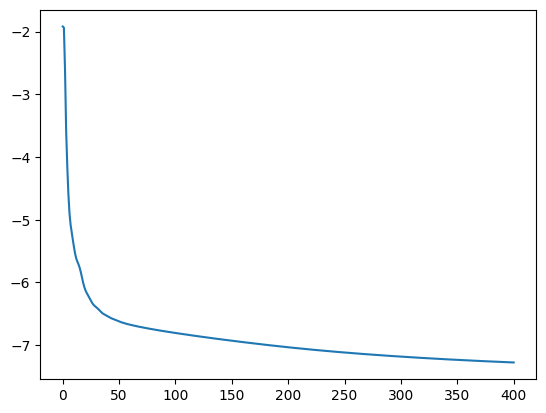

Epoch 400, loss = -7.2765764945752824


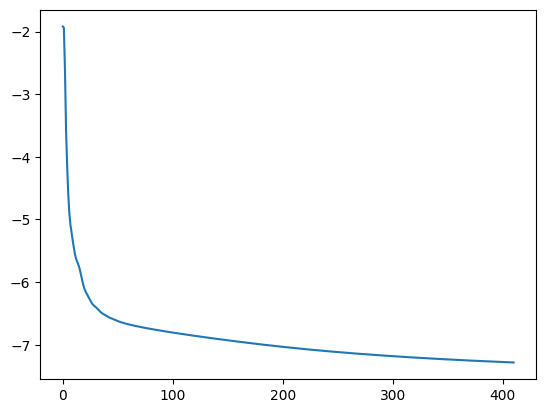

Epoch 410, loss = -7.2838593273186643


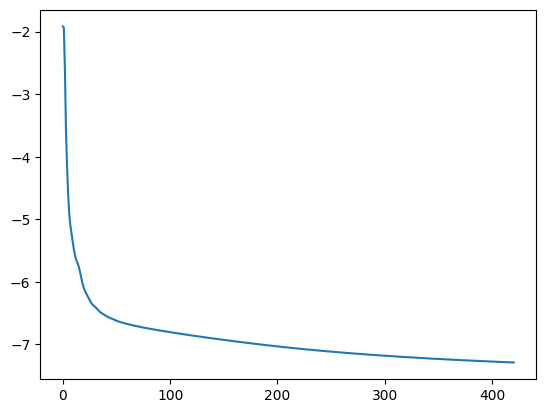

Epoch 420, loss = -7.2908546924717115


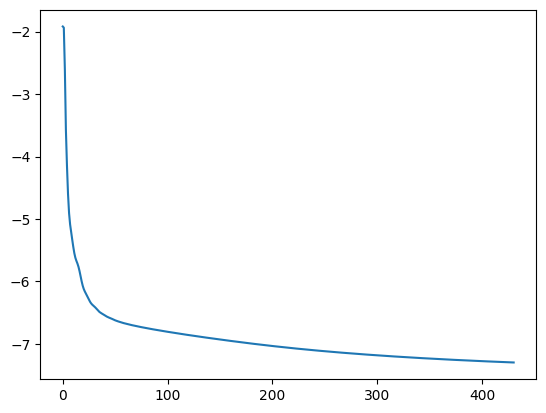

Epoch 430, loss = -7.2975761761227735


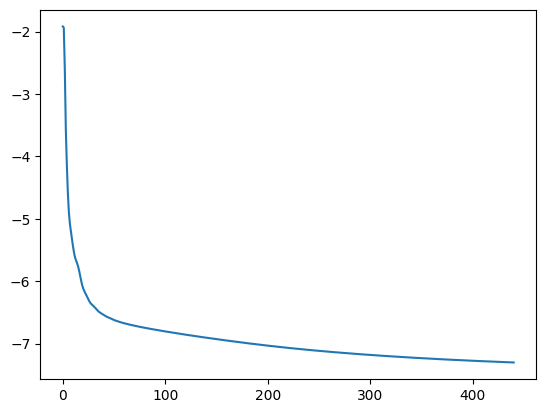

Epoch 440, loss = -7.3040389162281789


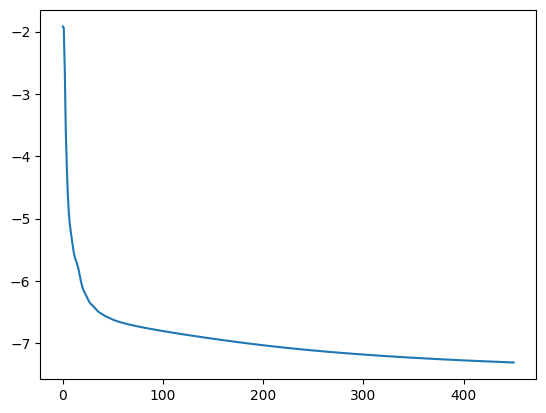

Epoch 450, loss = -7.3102652581867096


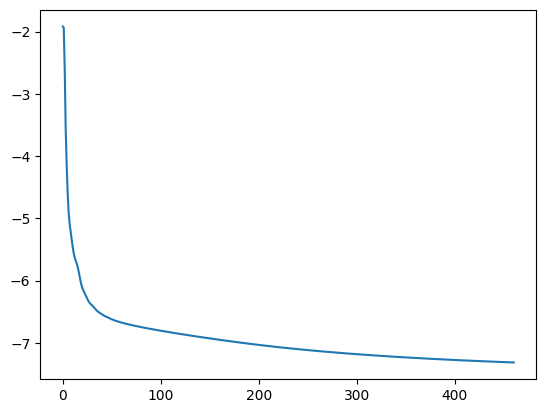

Epoch 460, loss = -7.3162680172082490


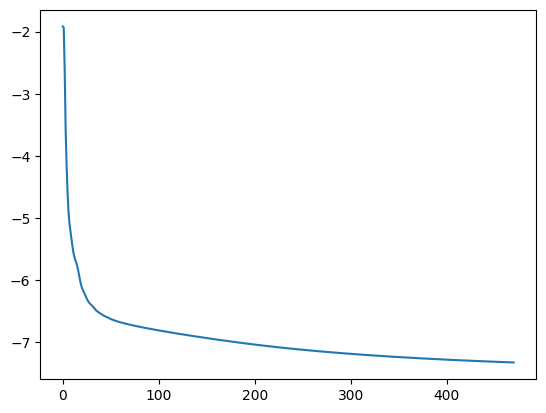

Epoch 470, loss = -7.3220671364589975


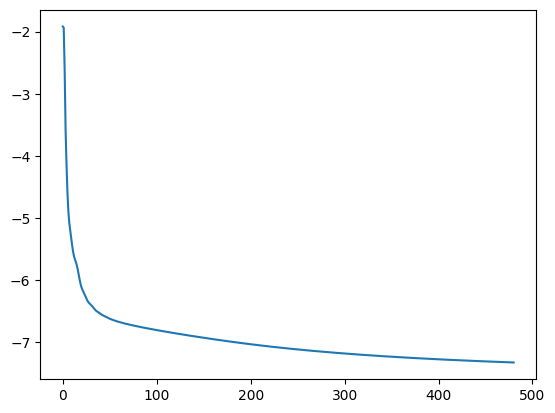

Epoch 480, loss = -7.3276612375285222


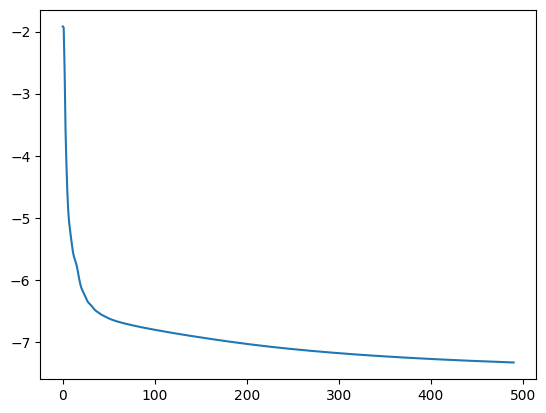

Epoch 490, loss = -7.3330660007366433


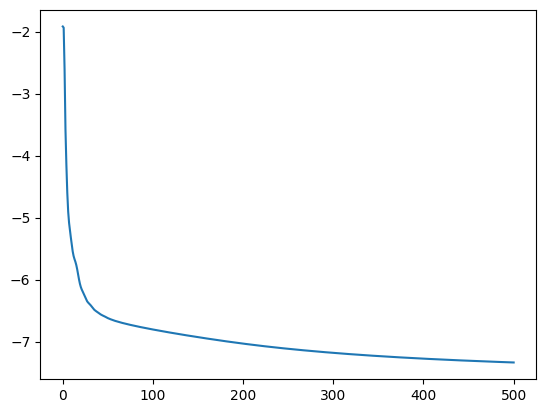

Epoch 500, loss = -7.3382958987384965


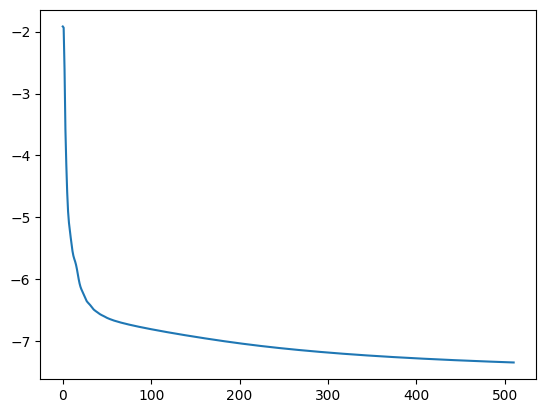

Epoch 510, loss = -7.3433579204830082


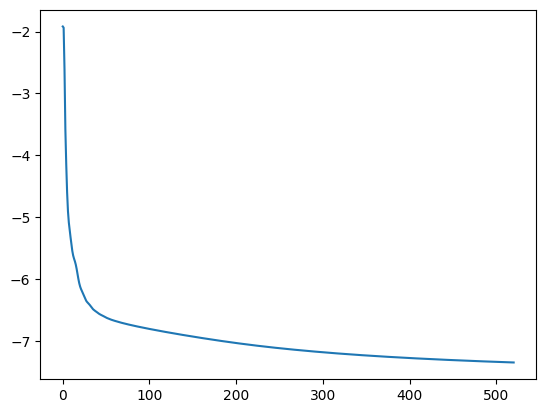

Epoch 520, loss = -7.3482537070443250


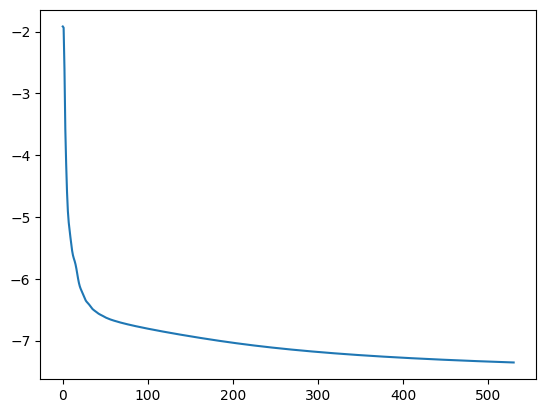

Epoch 530, loss = -7.3530003961514900


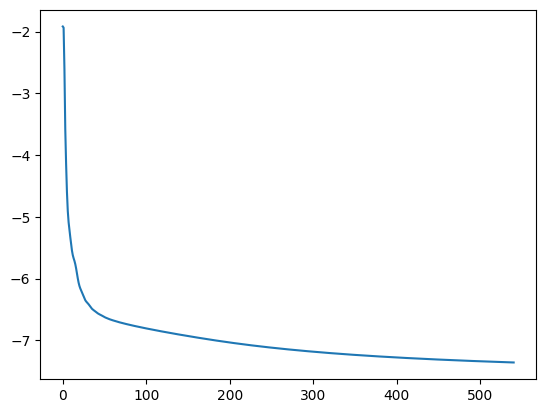

Epoch 540, loss = -7.3576033176293780


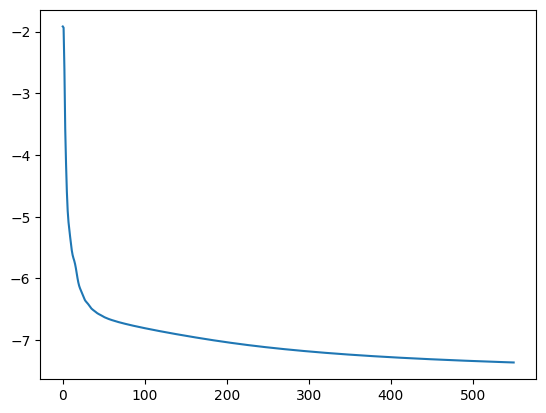

Epoch 550, loss = -7.3620710095429835


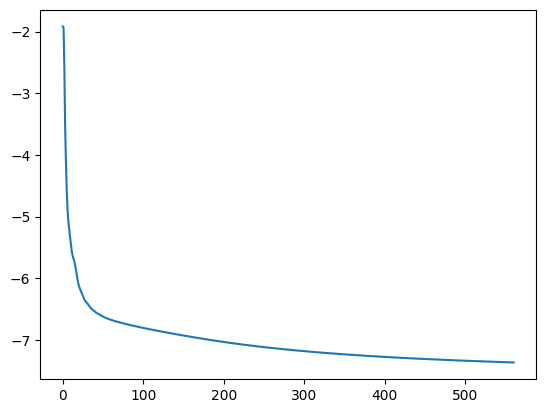

Epoch 560, loss = -7.3664070824060310


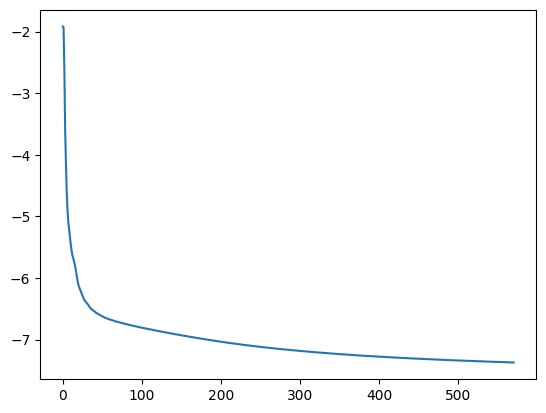

Epoch 570, loss = -7.3706137071405493


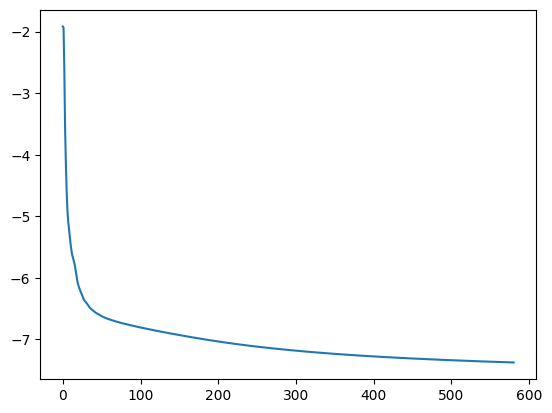

Epoch 580, loss = -7.3747016993800427


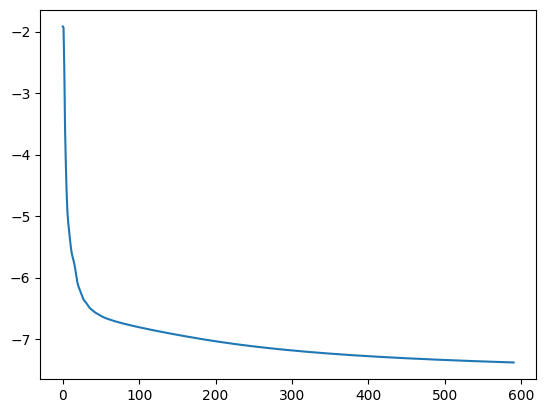

Epoch 590, loss = -7.3786760518374619


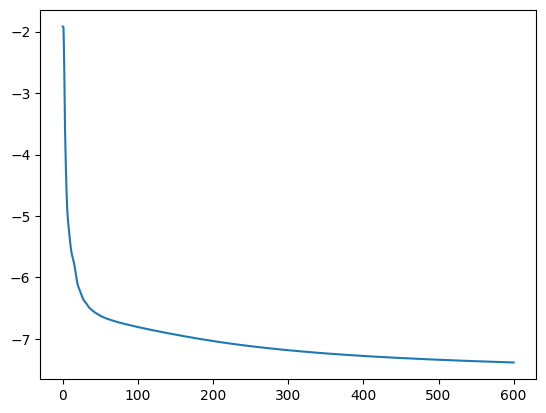

Epoch 600, loss = -7.3825398301646734


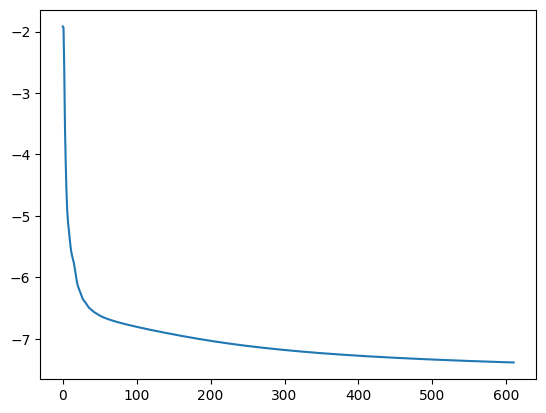

Epoch 610, loss = -7.3862993895815858


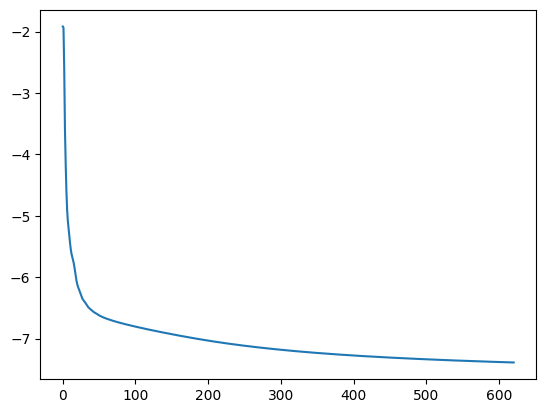

Epoch 620, loss = -7.3899584911947445


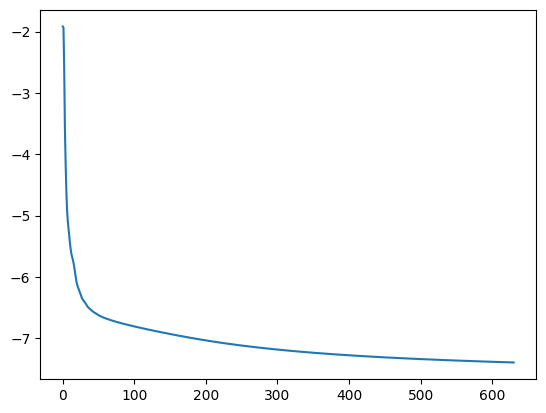

Epoch 630, loss = -7.3935196668234466


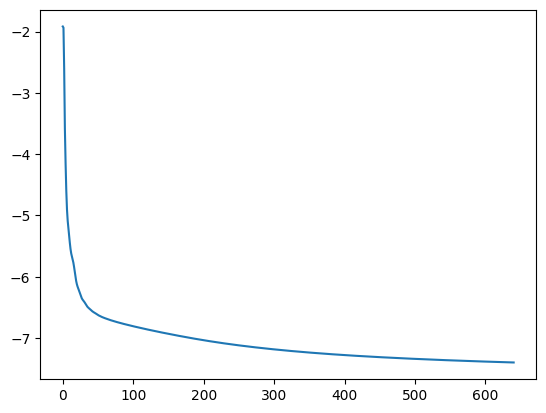

Epoch 640, loss = -7.3969907437017550


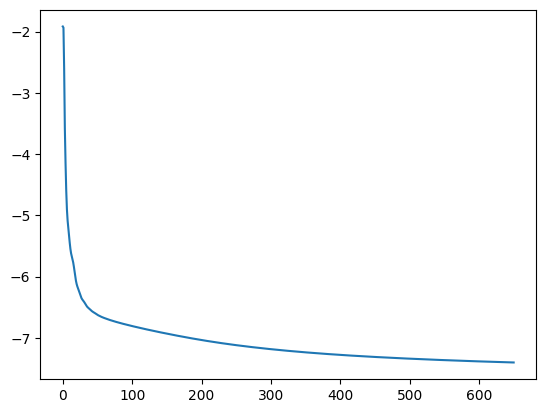

Epoch 650, loss = -7.4003746424714700


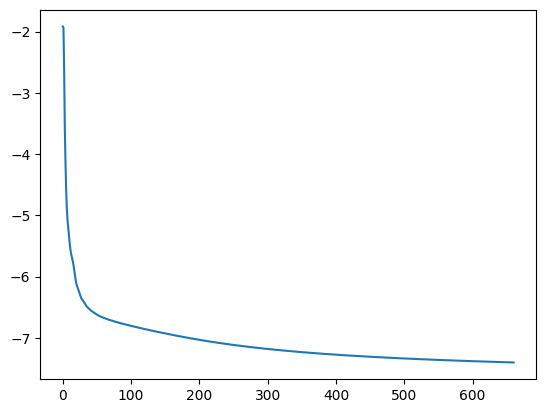

Epoch 660, loss = -7.4036729197215356


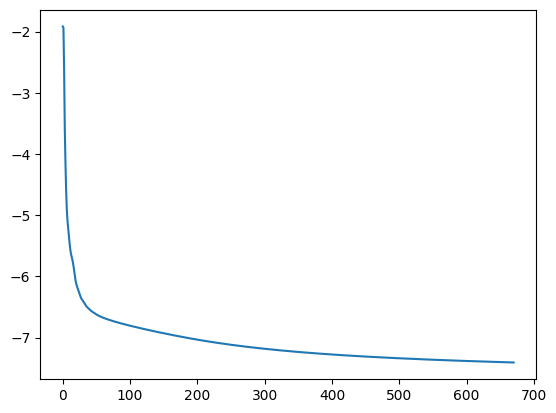

Epoch 670, loss = -7.4068900575746257


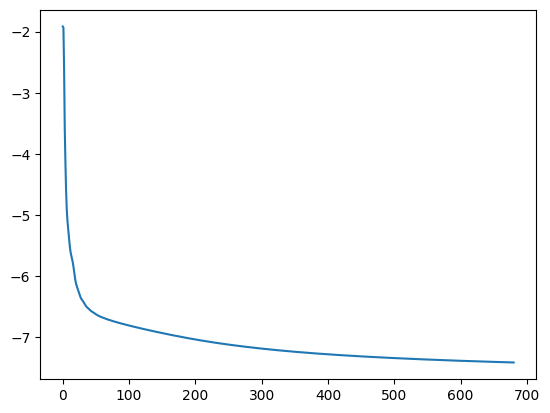

Epoch 680, loss = -7.4100324497046826


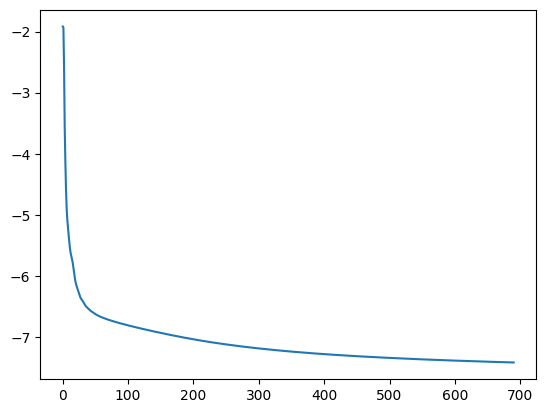

Epoch 690, loss = -7.4131019620205585


In [ ]:
model_config = {
    "l1": 0,
    "tv": 0,
    "noise": 0,
    "lr": 7e-10,
    "u": torch.tensor([0, 1, 0]),
    "theta": np.pi/8,
    "N": 640,
    "M": 540,
    "Z": 44
}

model_fft = model_train(model_config, epochs=700)

<Figure size 2000x1000 with 0 Axes>

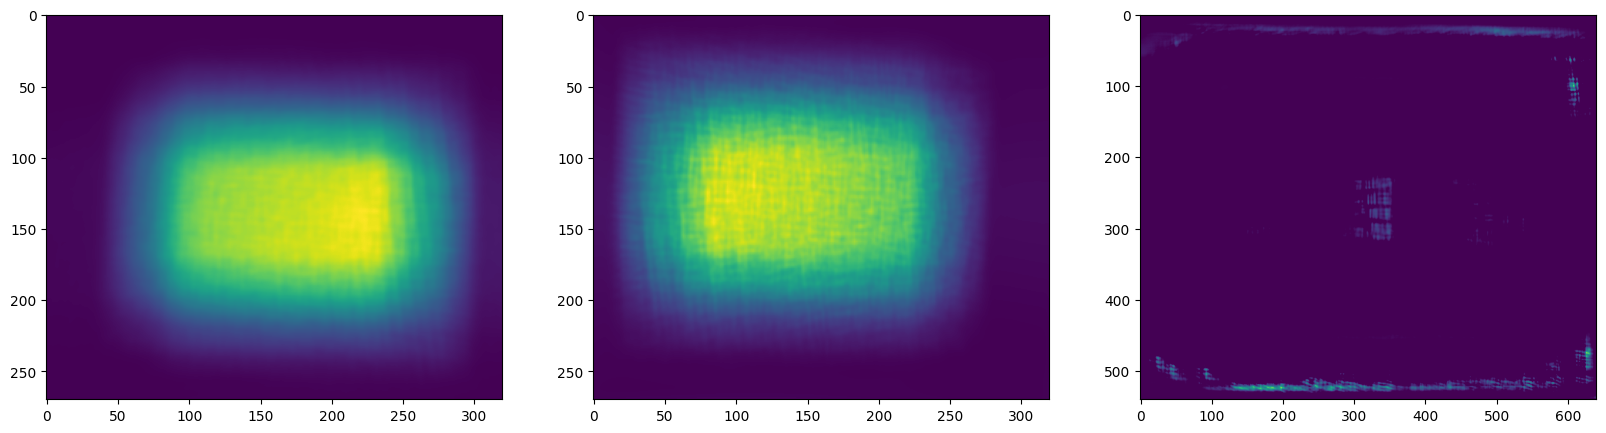

In [ ]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(model_fft(psf).detach().cpu().squeeze())
ax[1].imshow(ground_raw[:,270//2:~270//2+1,320//2:~320//2+1].cpu().squeeze())
ax[2].imshow(torch.maximum(model_fft.weight[20], torch.zeros(model_fft.weight[22].shape).to(device=device)).detach().cpu().squeeze())

# Export Results

In [ ]:
exportGIF(model_fft.weight, f"rrg_{model_fft.theta:.2f}_{model_fft.u}")

In [ ]:
model_fft.weight.shape

torch.Size([44, 540, 640])